In [1]:
import image_slicer

In [11]:
tiles = image_slicer.slice('sodoku.png', 81, save=False)
image_slicer.save_tiles(tiles, directory='.\image')

(<Tile #1 - _01_01.png>,
 <Tile #2 - _01_02.png>,
 <Tile #3 - _01_03.png>,
 <Tile #4 - _01_04.png>,
 <Tile #5 - _01_05.png>,
 <Tile #6 - _01_06.png>,
 <Tile #7 - _01_07.png>,
 <Tile #8 - _01_08.png>,
 <Tile #9 - _01_09.png>,
 <Tile #10 - _02_01.png>,
 <Tile #11 - _02_02.png>,
 <Tile #12 - _02_03.png>,
 <Tile #13 - _02_04.png>,
 <Tile #14 - _02_05.png>,
 <Tile #15 - _02_06.png>,
 <Tile #16 - _02_07.png>,
 <Tile #17 - _02_08.png>,
 <Tile #18 - _02_09.png>,
 <Tile #19 - _03_01.png>,
 <Tile #20 - _03_02.png>,
 <Tile #21 - _03_03.png>,
 <Tile #22 - _03_04.png>,
 <Tile #23 - _03_05.png>,
 <Tile #24 - _03_06.png>,
 <Tile #25 - _03_07.png>,
 <Tile #26 - _03_08.png>,
 <Tile #27 - _03_09.png>,
 <Tile #28 - _04_01.png>,
 <Tile #29 - _04_02.png>,
 <Tile #30 - _04_03.png>,
 <Tile #31 - _04_04.png>,
 <Tile #32 - _04_05.png>,
 <Tile #33 - _04_06.png>,
 <Tile #34 - _04_07.png>,
 <Tile #35 - _04_08.png>,
 <Tile #36 - _04_09.png>,
 <Tile #37 - _05_01.png>,
 <Tile #38 - _05_02.png>,
 <Tile #39 - _05_03.p

In [12]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [32]:
import cv2
import numpy as np

img_path = './image/_01_01.png'
img = cv2.bitwise_not(img)
img_cropped = img[10:-10, 10:-10]

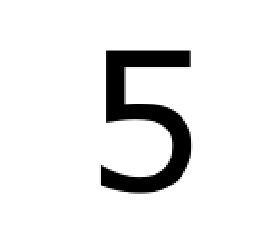

In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(img_cropped, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

In [76]:
answers = [5, 3, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 1, 9, 5, 0, 0, 0, 0, 9, 8, 0, 0, 0, 0, 6, 0, 8, 0, 0, 0, 6, 0, 0, 0, 3, 4, 0, 0, 
           8, 0, 3, 0, 0, 1, 7, 0, 0, 0, 2, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 4, 1, 9, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0, 7, 9]
data = []
for i in range(1, 10):
    for j in range(1, 10):
        img_path = f'./image/_0{j}_0{i}.png'
        img = cv2.imread(img_path, 0)
        img = cv2.bitwise_not(img)
        img_cropped = img[10:-10, 10:-10]
        to_predict = cv2.resize(img_cropped, (28, 28))
        data.append(to_predict.flatten())
pipeline.fit(data, answers)
# pipeline.fit(mnist.data, mnist.target)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [43]:
img_path = './image/_01_01.png'
img = cv2.imread(img_path, 0)
img = cv2.bitwise_not(img)
img_cropped = img[10:-10, 10:-10]

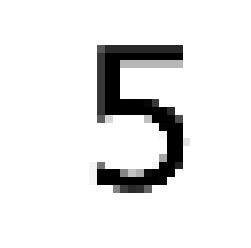

In [52]:
small = cv2.resize(img_cropped, (28, 28))
plt.imshow(small, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [83]:
tiles = image_slicer.slice('test.png', 81, save=False)
image_slicer.save_tiles(tiles, directory='.\\test')
print()

./test/_02_01.png


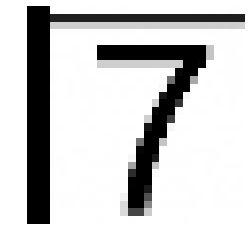

[0]
./test/_02_02.png


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


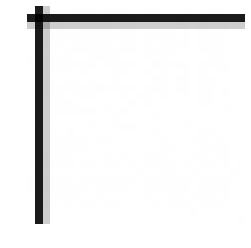

[0]
./test/_02_03.png


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


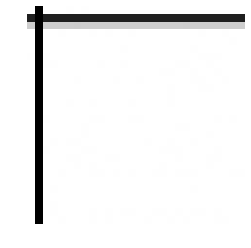

[0]
./test/_02_04.png


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


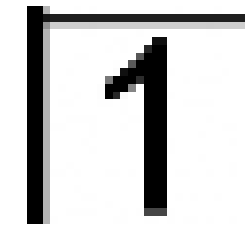

C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0]
./test/_02_05.png


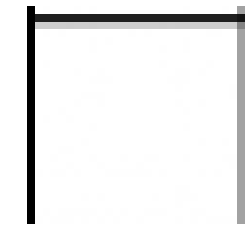

[0]
./test/_02_06.png


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


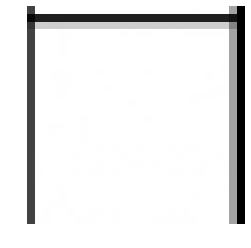

C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0]
./test/_02_07.png


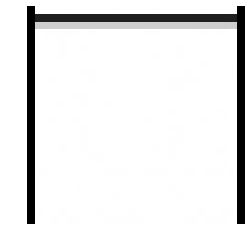

C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0]
./test/_02_08.png


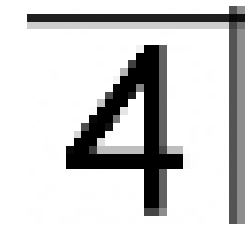

[7]
./test/_02_09.png


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


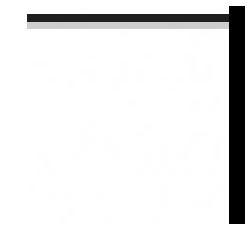

[0]


C:\Users\Brian\Anaconda3\envs\final\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [85]:
for i in range(1, 10):
    for j in range(2, 3):
        img_path = f'./test/_0{j}_0{i}.png'
        print(img_path)
        img = cv2.imread(img_path, 0)
        img = cv2.bitwise_not(img)
        img_cropped = img[10:-10, 10:-10]
        to_predict = cv2.resize(img, (28, 28))
        plt.imshow(to_predict, cmap=matplotlib.cm.binary, interpolation='nearest')
        plt.axis('off')
        plt.show()
        print(pipeline.predict(to_predict.flatten().reshape(1, -1)))

0.8271604938271605